# Behavior Analysis: Behavior Transition Motifs

Press SHIFT + ENTER to run code

### USER INPUT!

In [1]:
## Define project
project_name = 'project_ACC_MiniscopeSNI_3WeekMorphine'

# Select group and condition, see meta.py to see how you previously defined it for your project
selected_groups = ['NoInjury','SNI']
selected_conditions = ['Combined']


### Main Code: Create CSVs + Heatmaps w/ Behavior Transition Motifs

/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_73303/555703103.py:30: RuntimeWarning: invalid value encountered in divide
  tm_norm = tm_array / tm_array.sum(axis=1)
/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_73303/555703103.py:48: RuntimeWarning: invalid value encountered in divide
  all_prob_tm = all_count_tm / all_count_tm.sum(axis=1, keepdims=True)


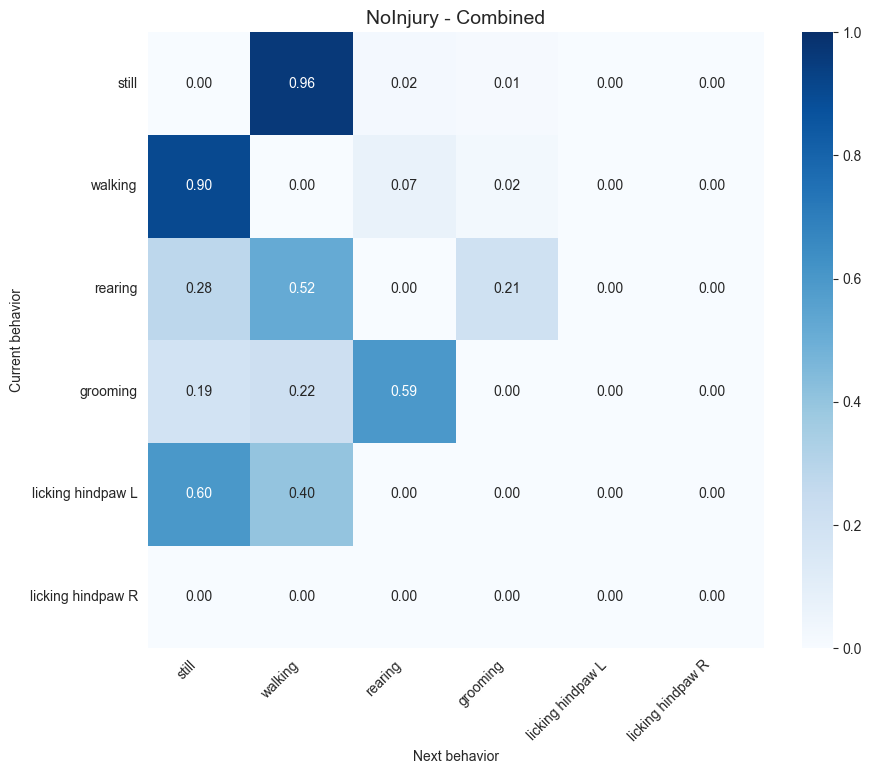

/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_73303/555703103.py:30: RuntimeWarning: invalid value encountered in divide
  tm_norm = tm_array / tm_array.sum(axis=1)
/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_73303/555703103.py:48: RuntimeWarning: invalid value encountered in divide
  all_prob_tm = all_count_tm / all_count_tm.sum(axis=1, keepdims=True)


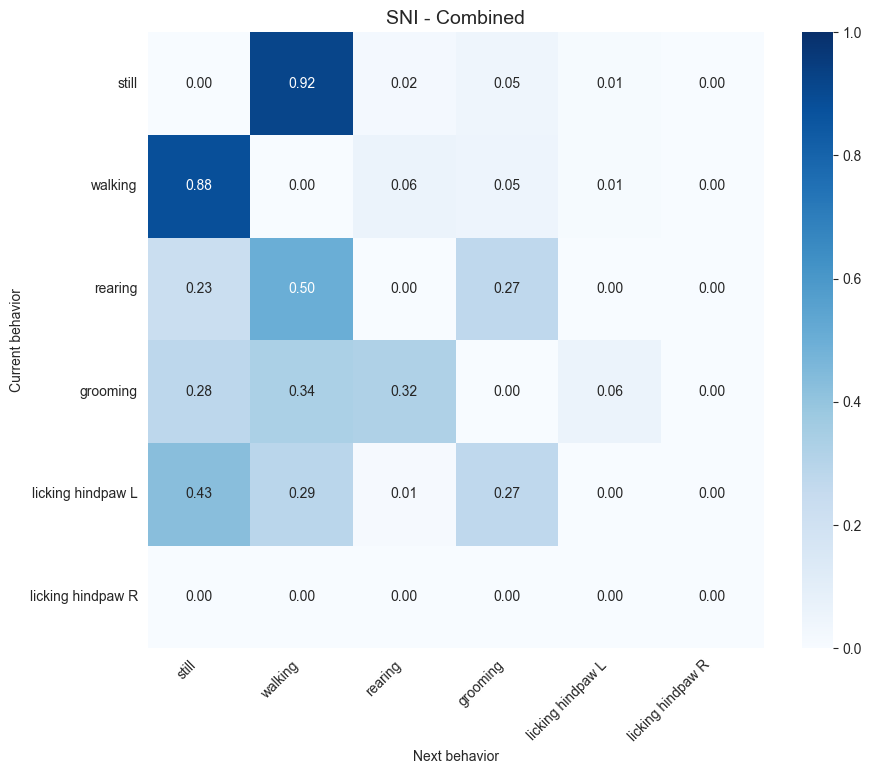

In [2]:
###### RUN DEPENDENCIES ######
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns

if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))

from utils.classification import load_behaviors
from utils.meta import *

###### Load Behaviors ######
behaviors = load_behaviors(f"../processed_dataset/{project_name}/behaviors_{project_name}.pkl")

# Define the directory path
directory_path = f"../processed_dataset/{project_name}/figures/behavior_transitions"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

def get_transitions(predict, behavior_classes):
    class_int = [int(i) for i, behavior_name in enumerate(behavior_classes)]
    tm = [[0] * len(class_int) for _ in class_int]
    for (i, j) in zip(predict, predict[1:]):
        tm[int(i)][int(j)] += 1
    tm_df = pd.DataFrame(tm)
    tm_array = np.array(tm)
    tm_norm = tm_array / tm_array.sum(axis=1)
    return tm_array, tm_norm

# Iterate through selected groups and conditions
for selected_condition in selected_conditions:
    for selected_group in selected_groups:
        if selected_group in behaviors and selected_condition in behaviors[selected_group]:
            class_int = [int(i) for i, behavior_name in enumerate(behavior_names)]
            all_count_tm = np.zeros((len(behavior_names), len(behavior_names)))

            file_keys = list(behaviors[selected_group][selected_condition].keys())
            
            # Aggregate transition counts across all files
            for file_name in file_keys:
                count_tm, prob_tm = get_transitions(behaviors[selected_group][selected_condition][file_name], behavior_names)
                np.fill_diagonal(count_tm, 0)  # Exclude self-transitions
                all_count_tm += count_tm

            all_prob_tm = all_count_tm / all_count_tm.sum(axis=1, keepdims=True)
            transmat_df = pd.DataFrame(all_prob_tm, index=behavior_names, columns=behavior_names)
            transmat_df = transmat_df.fillna(0)  # Fill NaN values with 0

            # Save the transition matrix as a CSV
            csv_filename = f"../processed_dataset/{project_name}/figures/behavior_transitions/behavior_transitions_{selected_group}_{selected_condition}.csv"
            transmat_df.to_csv(csv_filename)

            # Create a heatmap
            fig, ax = plt.subplots(figsize=(10, 8))
            sns.heatmap(transmat_df, annot=True, fmt=".2f", cmap='Blues', cbar=True,
                        vmin=0, vmax=1, ax=ax)

            # Customize the heatmap
            ax.set_title(f'{selected_group} - {selected_condition}', fontsize=14)
            ax.set_xlabel('Next behavior')
            ax.set_ylabel('Current behavior')
            ax.set_xticklabels(behavior_names, rotation=45, ha='right', fontsize=10)
            ax.set_yticklabels(behavior_names, fontsize=10)
            ax.set_aspect('equal', adjustable='box')

            # Save the heatmap as an SVG file
            fig_filename = f"../processed_dataset/{project_name}/figures/behavior_transitions/behavior_transitions_{project_name}_{selected_group}_{selected_condition}.svg"
            fig.savefig(fig_filename, dpi=600, bbox_inches='tight')
            plt.show()
        else:
            print(f"No data found for {selected_group} under condition {selected_condition}")

# ANALYSIS COMPLETE!

## Additional Transition Analyses   
## Behavior Transition Probabilities * WITHOUT Frequencies * -- 1) Behavior-Directed Graph + 2) Transition Matrix

Processing NoInjury - Combined


/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_73303/555703103.py:30: RuntimeWarning: invalid value encountered in divide
  tm_norm = tm_array / tm_array.sum(axis=1)
/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_73303/1119349450.py:131: RuntimeWarning: invalid value encountered in divide
  all_prob_tm = all_count_tm / all_count_tm.sum(axis=1, keepdims=True)


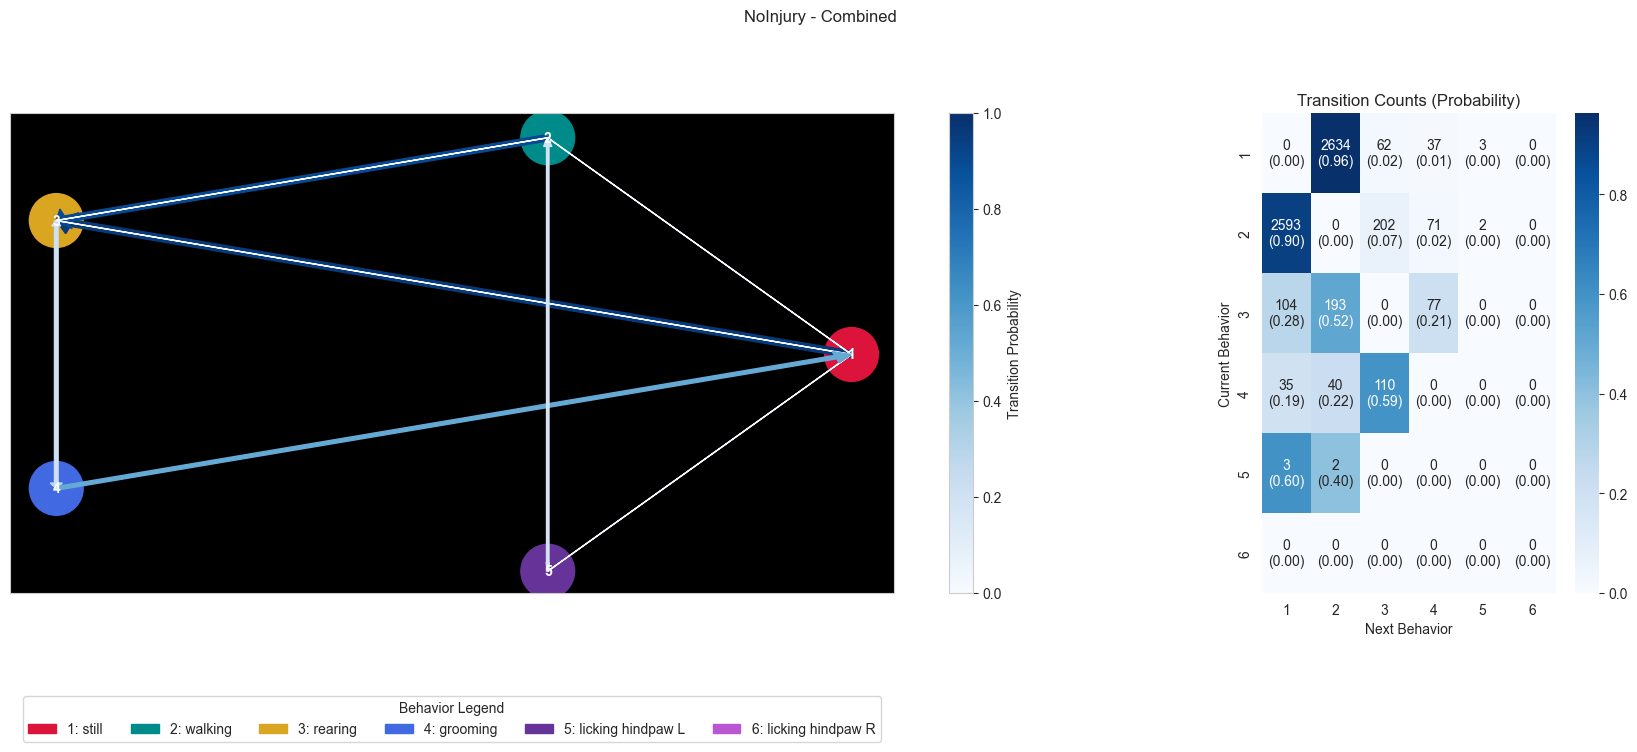

Processing SNI - Combined


/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_73303/555703103.py:30: RuntimeWarning: invalid value encountered in divide
  tm_norm = tm_array / tm_array.sum(axis=1)
/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_73303/1119349450.py:131: RuntimeWarning: invalid value encountered in divide
  all_prob_tm = all_count_tm / all_count_tm.sum(axis=1, keepdims=True)


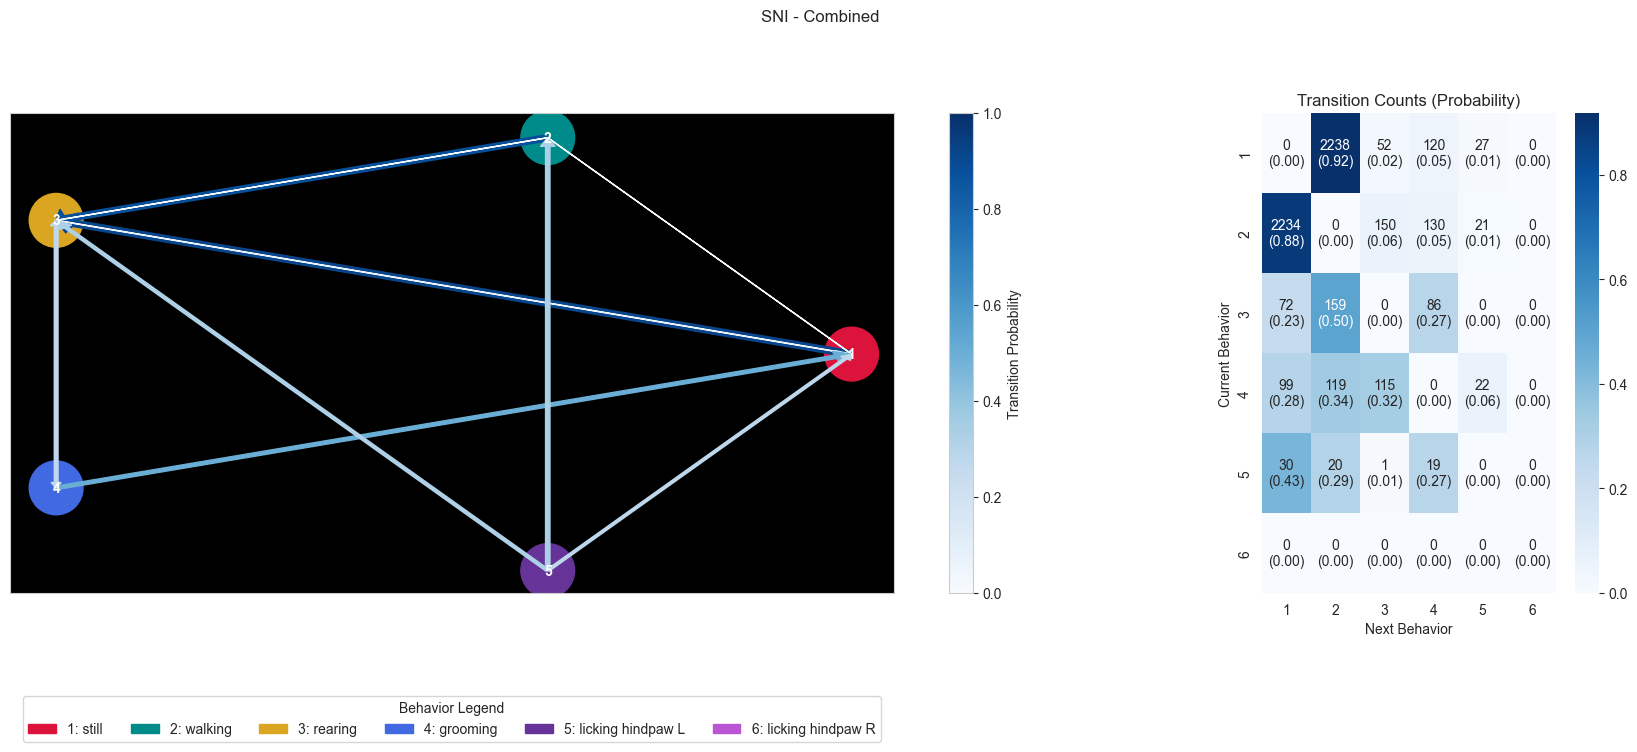

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sns
import os
import pandas as pd

# Behavior name to number mapping
behavior_mapping = {
    'still': 1,
    'walking': 2,
    'rearing': 3,
    'grooming': 4,
    'licking hindpaw L': 5,
    'licking hindpaw R': 6
}

# Color mapping for each behavior
color_mapping = {
    1: 'crimson',
    2: 'darkcyan',
    3: 'goldenrod',
    4: 'royalblue',
    5: 'rebeccapurple',
    6: 'mediumorchid'
}

# Reverse mapping for labels
reverse_behavior_mapping = {v: k for k, v in behavior_mapping.items()}

def filter_behaviors(transition_matrix, behavior_mapping):
    valid_behaviors = np.any(transition_matrix > 0, axis=0) | np.any(transition_matrix > 0, axis=1)
    filtered_matrix = transition_matrix[valid_behaviors][:, valid_behaviors]
    filtered_behavior_mapping = {i + 1: behavior for i, behavior in enumerate(np.array(list(behavior_mapping.values()))[valid_behaviors])}
    return filtered_matrix, filtered_behavior_mapping

def draw_arrows_without_labels(G, pos, prob_matrix, ax):
    ax.grid(False)
    ax.set_facecolor('black')
    node_colors = [color_mapping[n] for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color=node_colors, ax=ax)
    labels = {num: str(num) for num in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold', font_color='white', ax=ax)

    for (u, v), p in zip(G.edges(), prob_matrix.flatten()):
        if p > 0:
            start_pos = pos[u]
            end_pos = pos[v]
            dx, dy = end_pos[0] - start_pos[0], end_pos[1] - start_pos[1]
            width = 0.003 * p * 10
            head_width = 0.01 * p * 10
            head_length = 0.02 * np.sqrt(dx**2 + dy**2)
            ax.arrow(start_pos[0], start_pos[1], dx, dy, color=plt.cm.Blues(p), 
                      width=width, head_width=head_width, head_length=head_length, 
                      length_includes_head=True, zorder=2)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array(prob_matrix)
    plt.colorbar(sm, ax=ax, label='Transition Probability')

def plot_combined_heatmap(prob_matrix, count_matrix, behavior_mapping, ax):
    combined_data = np.array([[f"{int(c)}\n({p:.2f})" for c, p in zip(row_count, row_prob)] 
                               for row_count, row_prob in zip(count_matrix, prob_matrix)])
    sns.heatmap(prob_matrix, annot=combined_data, fmt="", cmap="Blues", cbar=True, 
                xticklabels=[str(i + 1) for i in range(len(behavior_mapping))],
                yticklabels=[str(i + 1) for i in range(len(behavior_mapping))],
                ax=ax)
    ax.set_title("Transition Counts (Probability)")
    ax.set_xlabel("Next Behavior")
    ax.set_ylabel("Current Behavior")

def create_combined_plot(transition_matrix, count_matrix, behavior_mapping, color_mapping, title, save_path, csv_filename, count_csv_filename):
    filtered_prob_matrix, filtered_behavior_mapping = filter_behaviors(transition_matrix, behavior_mapping)
    filtered_count_matrix, _ = filter_behaviors(count_matrix, behavior_mapping)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [3, 1]})

    G = nx.DiGraph()
    for behavior, num in filtered_behavior_mapping.items():
        G.add_node(num, label=str(num))

    for i in range(len(filtered_prob_matrix)):
        for j in range(len(filtered_prob_matrix[i])):
            if filtered_prob_matrix[i, j] > 0:
                G.add_edge(i + 1, j + 1, weight=filtered_prob_matrix[i, j])

    pos = nx.circular_layout(G)

    draw_arrows_without_labels(G, pos, filtered_prob_matrix, ax1)

    plot_combined_heatmap(transition_matrix, count_matrix, behavior_mapping, ax2)

    legend_handles = [mpatches.Patch(color=color_mapping[num], label=f"{num}: {reverse_behavior_mapping[num]}")
                      for num in behavior_mapping.values()]
    ax1.legend(handles=legend_handles, title="Behavior Legend", bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(legend_handles))

    fig.suptitle(title, y=0.98)
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.25)

    # Save the figure
    plt.savefig(save_path, dpi=300)
    plt.show()

    # Save the probability transition matrix as a CSV file
    transmat_df = pd.DataFrame(transition_matrix, index=[reverse_behavior_mapping[i + 1] for i in range(len(behavior_mapping))], 
                               columns=[reverse_behavior_mapping[i + 1] for i in range(len(behavior_mapping))])
    transmat_df.to_csv(csv_filename)

    # Save the count transition matrix as a CSV file
    countmat_df = pd.DataFrame(count_matrix, index=[reverse_behavior_mapping[i + 1] for i in range(len(behavior_mapping))], 
                               columns=[reverse_behavior_mapping[i + 1] for i in range(len(behavior_mapping))])
    countmat_df.to_csv(count_csv_filename)

def analyze_groups_and_conditions(selected_groups, selected_conditions, project_name):
    for group in selected_groups:
        for condition in selected_conditions:
            print(f"Processing {group} - {condition}")
            
            all_count_tm = np.zeros((len(behavior_mapping), len(behavior_mapping)))

            if group in behaviors and condition in behaviors[group]:
                file_keys = list(behaviors[group][condition].keys())

                for file_name in file_keys:
                    count_tm, prob_tm = get_transitions(behaviors[group][condition][file_name], list(behavior_mapping.keys()))
                    np.fill_diagonal(count_tm, 0)
                    all_count_tm += count_tm

                all_prob_tm = all_count_tm / all_count_tm.sum(axis=1, keepdims=True)
                all_prob_tm = np.nan_to_num(all_prob_tm)

                # Define save paths
                save_path = f"../processed_dataset/{project_name}/figures/behavior_transitions-alt1/behavior_transitions-alt1_{group}_{condition}.svg"
                csv_filename = f"../processed_dataset/{project_name}/figures/behavior_transitions-alt1/behavior_transitions-alt1_{group}_{condition}_probability.csv"
                count_csv_filename = f"../processed_dataset/{project_name}/figures/behavior_transitions-alt1/behavior_transitions-alt1_{group}_{condition}_counts.csv"

                # Ensure the directory exists
                os.makedirs(os.path.dirname(save_path), exist_ok=True)

                # Create and save the combined plot
                create_combined_plot(all_prob_tm, all_count_tm, behavior_mapping, color_mapping, 
                                     title=f"{group} - {condition}", save_path=save_path, 
                                     csv_filename=csv_filename, count_csv_filename=count_csv_filename)


# Load Behaviors
behaviors = load_behaviors(f"../processed_dataset/{project_name}/behaviors_{project_name}.pkl")

# Analyze and plot for all groups and conditions
analyze_groups_and_conditions(selected_groups, selected_conditions, project_name)

## Behavior Transition Probabilities * w/ Frequencies * -- 1) Behavior-Directed Graph + 2) Transition Matrix

Processing NoInjury - Combined


/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_73303/555703103.py:30: RuntimeWarning: invalid value encountered in divide
  tm_norm = tm_array / tm_array.sum(axis=1)
/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_73303/3678618306.py:134: RuntimeWarning: invalid value encountered in divide
  all_prob_tm = all_count_tm / all_count_tm.sum(axis=1, keepdims=True)


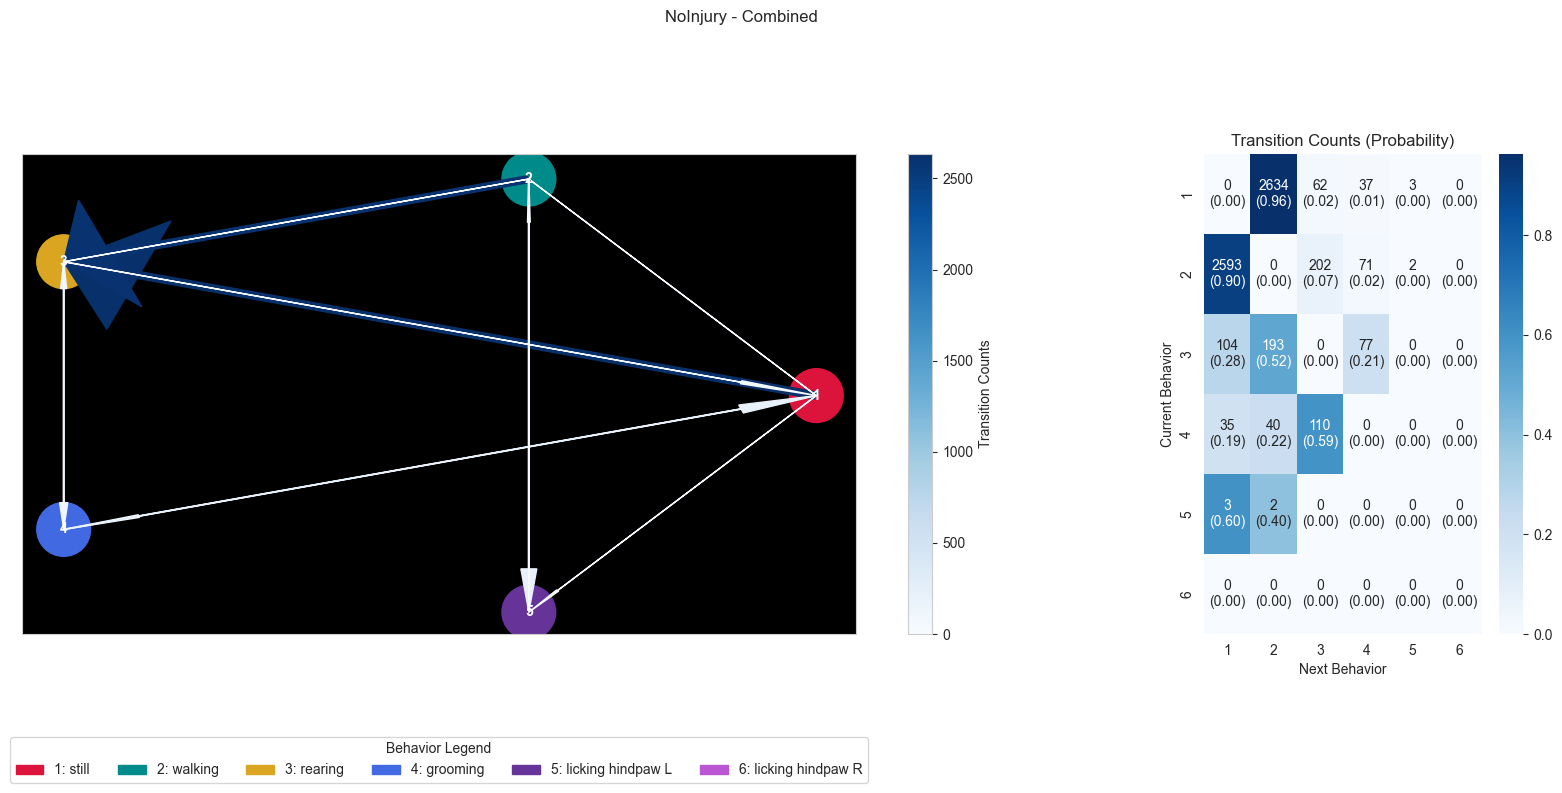

Processing SNI - Combined


/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_73303/555703103.py:30: RuntimeWarning: invalid value encountered in divide
  tm_norm = tm_array / tm_array.sum(axis=1)
/var/folders/9t/fsgf0mhs7xl9nc_xmd9v_c780000gn/T/ipykernel_73303/3678618306.py:134: RuntimeWarning: invalid value encountered in divide
  all_prob_tm = all_count_tm / all_count_tm.sum(axis=1, keepdims=True)


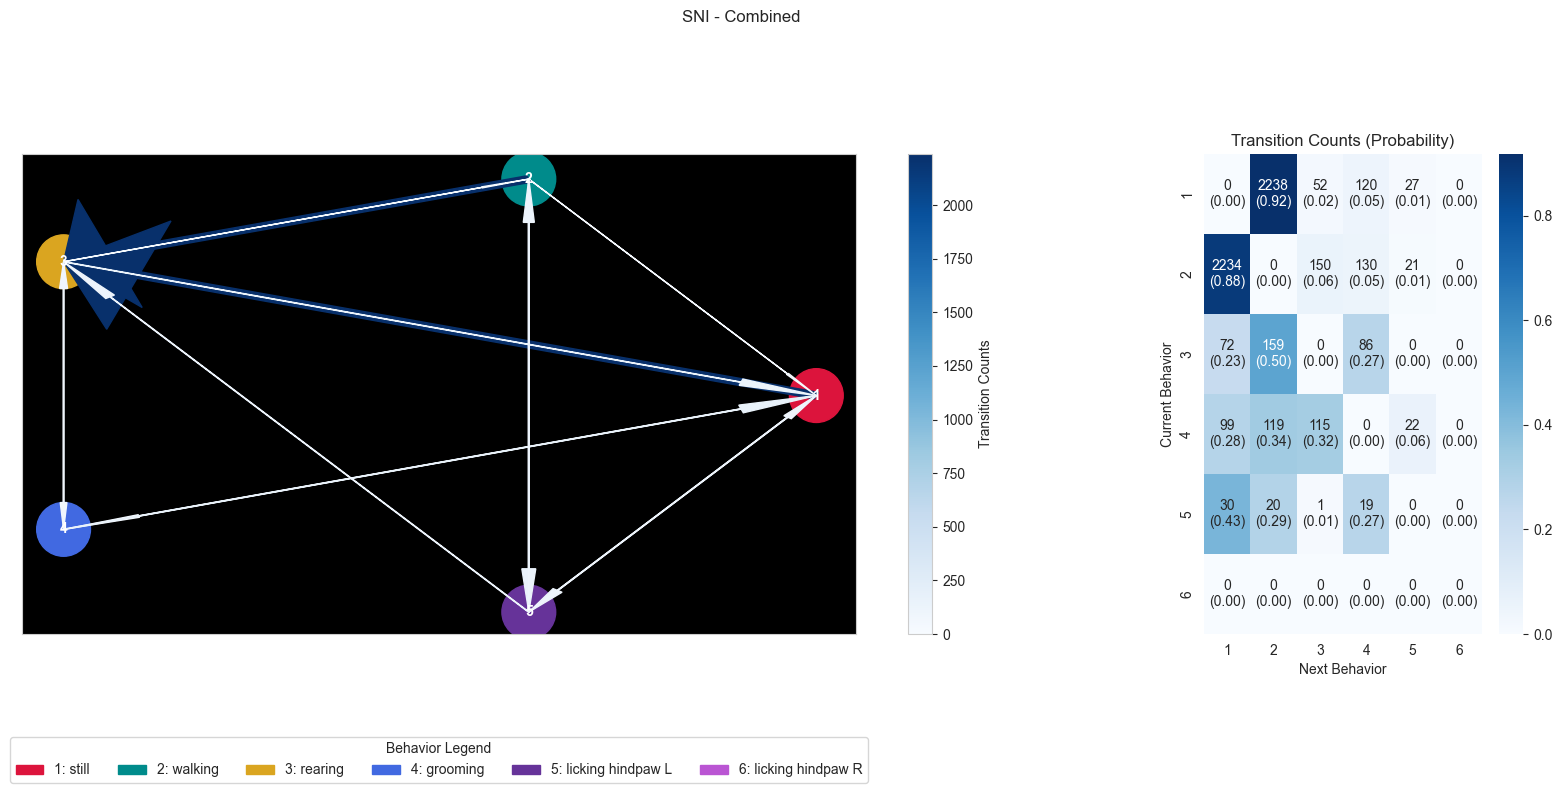

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sns
import os
import pandas as pd

# Behavior name to number mapping
behavior_mapping = {
    'still': 1,
    'walking': 2,
    'rearing': 3,
    'grooming': 4,
    'licking hindpaw L': 5,
    'licking hindpaw R': 6
}

# Color mapping for each behavior
color_mapping = {
    1: 'crimson',
    2: 'darkcyan',
    3: 'goldenrod',
    4: 'royalblue',
    5: 'rebeccapurple',
    6: 'mediumorchid'
}

# Reverse mapping for labels
reverse_behavior_mapping = {v: k for k, v in behavior_mapping.items()}

def filter_behaviors(transition_matrix, behavior_mapping):
    valid_behaviors = np.any(transition_matrix > 0, axis=0) | np.any(transition_matrix > 0, axis=1)
    filtered_matrix = transition_matrix[valid_behaviors][:, valid_behaviors]
    filtered_behavior_mapping = {i + 1: behavior for i, behavior in enumerate(np.array(list(behavior_mapping.values()))[valid_behaviors])}
    return filtered_matrix, filtered_behavior_mapping

def draw_arrows_with_thickness_based_on_counts(G, pos, count_matrix, ax):
    ax.grid(False)
    ax.set_facecolor('black')
    node_colors = [color_mapping[n] for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color=node_colors, ax=ax)
    labels = {num: str(num) for num in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold', font_color='white', ax=ax)

    max_count = np.max(count_matrix)

    for (u, v), c in zip(G.edges(), count_matrix.flatten()):
        if c > 0:
            start_pos = pos[u]
            end_pos = pos[v]
            dx, dy = end_pos[0] - start_pos[0], end_pos[1] - start_pos[1]
            width = 0.003 * (c / max_count) * 10  # Scale thickness based on counts
            head_width = 0.05 * (c / max_count) * 10  # Increase the size of the arrowheads
            head_length = 0.1 * np.sqrt(dx**2 + dy**2)  # Adjust the head length for visibility
            color = plt.cm.Blues(c / max_count)  # Use the same color map for arrows
            ax.arrow(start_pos[0], start_pos[1], dx, dy, color=color, 
                      width=width, head_width=head_width, head_length=head_length, 
                      length_includes_head=True, zorder=2)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=max_count))
    sm.set_array(count_matrix)
    plt.colorbar(sm, ax=ax, label='Transition Counts')

def plot_combined_heatmap(prob_matrix, count_matrix, behavior_mapping, ax):
    combined_data = np.array([[f"{int(c)}\n({p:.2f})" for c, p in zip(row_count, row_prob)] 
                               for row_count, row_prob in zip(count_matrix, prob_matrix)])
    sns.heatmap(prob_matrix, annot=combined_data, fmt="", cmap="Blues", cbar=True, 
                xticklabels=[str(i + 1) for i in range(len(behavior_mapping))],
                yticklabels=[str(i + 1) for i in range(len(behavior_mapping))],
                ax=ax)
    ax.set_title("Transition Counts (Probability)")
    ax.set_xlabel("Next Behavior")
    ax.set_ylabel("Current Behavior")

def create_combined_plot(transition_matrix, count_matrix, behavior_mapping, color_mapping, title, save_path, csv_filename, count_csv_filename):
    filtered_prob_matrix, filtered_behavior_mapping = filter_behaviors(transition_matrix, behavior_mapping)
    filtered_count_matrix, _ = filter_behaviors(count_matrix, behavior_mapping)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [3, 1]})

    G = nx.DiGraph()
    for behavior, num in filtered_behavior_mapping.items():
        G.add_node(num, label=str(num))

    for i in range(len(filtered_prob_matrix)):
        for j in range(len(filtered_prob_matrix[i])):
            if filtered_prob_matrix[i, j] > 0:
                G.add_edge(i + 1, j + 1, weight=filtered_prob_matrix[i, j])

    pos = nx.circular_layout(G)

    draw_arrows_with_thickness_based_on_counts(G, pos, filtered_count_matrix, ax1)

    plot_combined_heatmap(transition_matrix, count_matrix, behavior_mapping, ax2)

    legend_handles = [mpatches.Patch(color=color_mapping[num], label=f"{num}: {reverse_behavior_mapping[num]}")
                      for num in behavior_mapping.values()]
    ax1.legend(handles=legend_handles, title="Behavior Legend", bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(legend_handles))

    fig.suptitle(title, y=0.98)
    plt.subplots_adjust(left=0.1, right=0.95, top=0.8, bottom=0.2)

    # Save the figure
    plt.savefig(save_path, dpi=300)
    plt.show()

    # Save the probability transition matrix as a CSV file
    transmat_df = pd.DataFrame(transition_matrix, index=[reverse_behavior_mapping[i + 1] for i in range(len(behavior_mapping))], 
                               columns=[reverse_behavior_mapping[i + 1] for i in range(len(behavior_mapping))])
    transmat_df.to_csv(csv_filename)

    # Save the count transition matrix as a CSV file
    countmat_df = pd.DataFrame(count_matrix, index=[reverse_behavior_mapping[i + 1] for i in range(len(behavior_mapping))], 
                               columns=[reverse_behavior_mapping[i + 1] for i in range(len(behavior_mapping))])
    countmat_df.to_csv(count_csv_filename)

def analyze_groups_and_conditions(selected_groups, selected_conditions, project_name):
    for group in selected_groups:
        for condition in selected_conditions:
            print(f"Processing {group} - {condition}")
            
            all_count_tm = np.zeros((len(behavior_mapping), len(behavior_mapping)))

            if group in behaviors and condition in behaviors[group]:
                file_keys = list(behaviors[group][condition].keys())

                for file_name in file_keys:
                    count_tm, prob_tm = get_transitions(behaviors[group][condition][file_name], list(behavior_mapping.keys()))
                    np.fill_diagonal(count_tm, 0)
                    all_count_tm += count_tm

                all_prob_tm = all_count_tm / all_count_tm.sum(axis=1, keepdims=True)
                all_prob_tm = np.nan_to_num(all_prob_tm)

                # Define save paths
                save_path = f"../processed_dataset/{project_name}/figures/behavior_transitions-alt2/behavior_transitions-alt2_{group}_{condition}.svg"
                csv_filename = f"../processed_dataset/{project_name}/figures/behavior_transitions-alt2/behavior_transitions-alt2_{group}_{condition}_probability.csv"
                count_csv_filename = f"../processed_dataset/{project_name}/figures/behavior_transitions-alt2/behavior_transitions-alt2_{group}_{condition}_counts.csv"

                # Ensure the directory exists
                os.makedirs(os.path.dirname(save_path), exist_ok=True)

                # Create and save the combined plot
                create_combined_plot(all_prob_tm, all_count_tm, behavior_mapping, color_mapping, 
                                     title=f"{group} - {condition}", save_path=save_path, 
                                     csv_filename=csv_filename, count_csv_filename=count_csv_filename)

# Load Behaviors
behaviors = load_behaviors(f"../processed_dataset/{project_name}/behaviors_{project_name}.pkl")

# Analyze and plot for all groups and conditions
analyze_groups_and_conditions(selected_groups, selected_conditions, project_name)